In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [10]:
df_teste.dropna(inplace=True)
df_treino.dropna(inplace=True)

### Definindo arquitetura da rede MLP

In [11]:
# Definir a arquitetura do MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

# Lique Relu Direcional
# Trazer os chutes
# Separar por step
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)

        return out



### Normalizando dados, definindo entrada e saída

In [12]:
# Selecionar colunas de entrada e saída
colunas_entrada = ['Variaveis entrada']
coluna_saida = 'Saida'

# Extrair os dados de entrada e saída dos dataframes
entrada_treino = df_treino[colunas_entrada].values
saida_treino = df_treino[coluna_saida].values

entrada_teste = df_teste[colunas_entrada].values
saida_teste = df_teste[coluna_saida].values

# Criando instancia StandardScaler
scaler = StandardScaler()
scaler.fit(entrada_treino)

# Aplicando normalização nos dados de treino e teste
entrada_treino = scaler.transform(entrada_treino)
entrada_teste = scaler.transform(entrada_teste)

# Converter para tensores do PyTorch
entrada_treino = torch.tensor(entrada_treino, dtype=torch.float32)
entrada_teste = torch.tensor(entrada_teste, dtype=torch.float32)
saida_treino = torch.tensor(saida_treino, dtype=torch.float32)
saida_teste = torch.tensor(saida_teste, dtype=torch.float32)

# Criar DataLoader para os conjuntos de dados de treino e teste
dataset_treino = TensorDataset(entrada_treino, saida_treino)
dataloader_treino = DataLoader(dataset_treino, batch_size=32, shuffle=True)

dataset_teste = TensorDataset(entrada_teste, saida_teste)
dataloader_teste = DataLoader(dataset_teste, batch_size=32)

### Treinando a rede e armazenando a loss

In [13]:
train_loss_values = []
test_loss_values = []
predictions = []
valores_corretos = []

# Definir as dimensões de entrada, camada oculta e saída
input_size = len(colunas_entrada)  # Número de colunas de entrada
hidden_size = 50 
hidden_size = 50 # Adicionar mais uma camada oculta
output_size = 1  # Número de colunas de saída

# Criar uma instância do MLP
mlp = MLP(input_size, hidden_size, hidden_size, output_size)

# Definir função de perda e otimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Treinamento do modelo
num_epochs = 60
for epoch in range(num_epochs):
    mlp.train()
    running_loss = 0.0

    for batch_inputs, batch_labels in dataloader_treino:
        optimizer.zero_grad()
        batch_outputs = mlp(batch_inputs)
        batch_outputs = torch.clamp(batch_outputs, 0, 100)  # Limita o range de chutes
        loss = criterion(batch_outputs, batch_labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calcular a média da loss no conjunto de treinamento
    train_loss = running_loss / len(dataloader_treino)
    train_loss_values.append(train_loss)

    # Avaliação do modelo no conjunto de teste
    mlp.eval()
    with torch.no_grad():
        test_outputs = mlp(entrada_teste)
        test_outputs = torch.clamp(test_outputs, 0, 100) # Limita o range de chutes
        test_loss = criterion(test_outputs, saida_teste.unsqueeze(1))
        test_loss = test_loss.item()
        test_loss_values.append(test_loss)
        predictions.extend(test_outputs.detach().numpy().flatten())
        valores_corretos.extend(saida_teste.numpy())

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/60, Train Loss: 12.2372, Test Loss: 3.8887
Epoch 2/60, Train Loss: 0.1015, Test Loss: 1.9162
Epoch 3/60, Train Loss: 0.0250, Test Loss: 0.9251
Epoch 4/60, Train Loss: 0.0219, Test Loss: 0.9705
Epoch 5/60, Train Loss: 0.0198, Test Loss: 2.9054
Epoch 6/60, Train Loss: 0.0184, Test Loss: 0.2810
Epoch 7/60, Train Loss: 0.0178, Test Loss: 0.5285
Epoch 8/60, Train Loss: 0.0174, Test Loss: 0.5113
Epoch 9/60, Train Loss: 0.0171, Test Loss: 1.3031
Epoch 10/60, Train Loss: 0.0173, Test Loss: 1.0025
Epoch 11/60, Train Loss: 0.0167, Test Loss: 0.8294
Epoch 12/60, Train Loss: 0.0163, Test Loss: 0.3257
Epoch 13/60, Train Loss: 0.0159, Test Loss: 0.7446
Epoch 14/60, Train Loss: 0.0160, Test Loss: 1.0516
Epoch 15/60, Train Loss: 0.0161, Test Loss: 0.5253
Epoch 16/60, Train Loss: 0.0160, Test Loss: 0.9969
Epoch 17/60, Train Loss: 0.0157, Test Loss: 0.8606
Epoch 18/60, Train Loss: 0.0158, Test Loss: 0.1465
Epoch 19/60, Train Loss: 0.0158, Test Loss: 0.3781
Epoch 20/60, Train Loss: 0.0157, Test L

In [14]:
comp = pd.DataFrame({'pred': predictions, 'val': valores_corretos})
comp.to_csv('comp4.csv', index=False)

In [3]:
comp

,pred,val
0,100.000000,100.000000
1,100.000000,100.000000
2,100.000000,100.000000
3,100.000000,100.000000
4,100.000000,100.000000
...,...,...
62985055,55.353977,54.000000
62985056,55.361073,54.000000
62985057,55.385704,54.000000
62985058,55.385590,54.000000


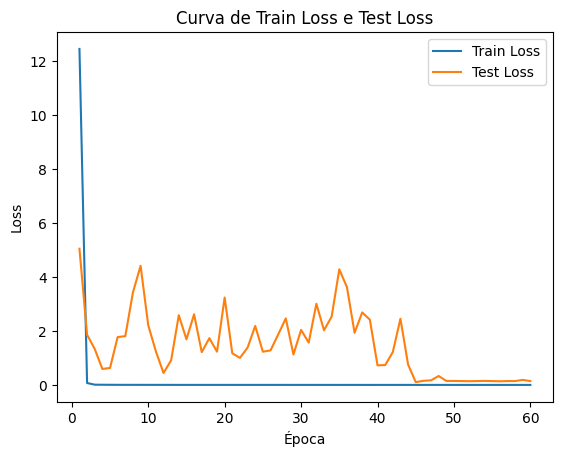

In [14]:
# Gráfico de train_loss e test_loss
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_loss_values, label='Train Loss')
plt.plot(epochs, test_loss_values, label='Test Loss')

plt.title('Curva de Train Loss e Test Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
comp = pd.DataFrame({'pred': predictions, 'val': valores_corretos})
comp

,pred,val
0,100.000000,100.000000
1,100.000000,100.000000
2,100.000000,100.000000
3,100.000000,100.000000
4,100.000000,100.000000
...,...,...
20995015,54.024475,54.000000
20995016,54.041431,54.000000
20995017,54.151585,54.000000
20995018,54.182106,54.000000


In [ ]:
comp['dif'] = comp['pred'] - comp['val']
comp

,pred,val,dif
0,100.000000,100.000000,0.000000
1,100.000000,100.000000,0.000000
2,100.000000,100.000000,0.000000
3,100.000000,100.000000,0.000000
4,100.000000,100.000000,0.000000
...,...,...,...
20995015,54.024475,54.000000,0.024475
20995016,54.041431,54.000000,0.041431
20995017,54.151585,54.000000,0.151585
20995018,54.182106,54.000000,0.182106


Text(0.5, 1.0, 'Gráfico de Linha')

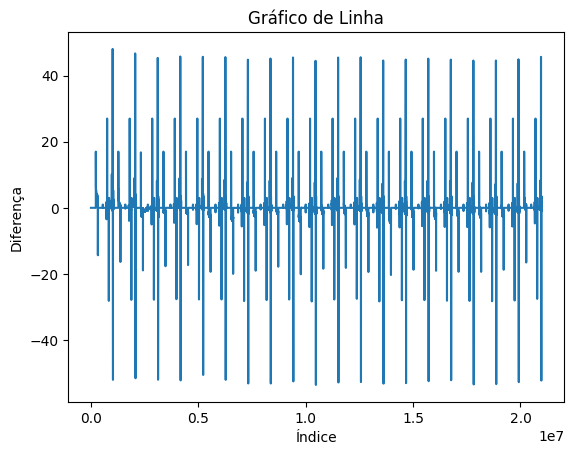

In [ ]:
# Plotar o gráfico de linha usando o índice (eixo x) e a coluna 'diferenca' (eixo y)
plt.plot(comp.index, comp['dif'])

# Personalizar o gráfico
plt.xlabel('Índice')
plt.ylabel('Diferença')
plt.title('Gráfico de Linha')

In [ ]:
posicoes = np.where(comp['dif'] > 1)[0]
print(posicoes)

[  226207   226208   226209 ... 20988640 20989251 20992175]
